# 02- Exploratory Data Analysis (EDA)

In [1]:
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_pickle('../data/cleaned_tweets.pkl')

In [3]:
# choosing a subset of tweets that have more/equal than 10 and less/equal than 20 words

df = df[(df.num_words>=10) & (df.num_words<=20)]
df.category.value_counts()

true          1891
unreliable    1298
Name: category, dtype: int64

In [4]:
# sub sample only 500 tweets from each category

df = pd.concat([df[df.category == 'unreliable'].sample(n=500, random_state=42),
                df[df.category == 'true'].sample(n=500, random_state=42)]).reset_index(drop=True)

In [5]:
df.head()

,text,region,category,label,cleaned,num_words
0,thousands of citizens demonstrate in rome agai...,europe,unreliable,0,thousand citizen demonstrate rome coronavirus ...,13
1,american citizens have placed a nude statue of...,india,unreliable,0,american citizen placed nude statue president ...,16
2,"people in the city of mumbai were raising ""pak...",india,unreliable,0,people city mumbai raising pakistan zindabad s...,13
3,house speaker nancy pelosi delete a february 2...,united states,unreliable,0,house speaker nancy pelosi delete february vid...,14
4,black body bags being referred to as deaths in...,india,unreliable,0,black body bag referred death new york reason ...,10


In [6]:
bow = []
for word in df.cleaned.str.split().to_list():
    bow += word

In [7]:
len(bow)

13491

In [8]:
bow_true = []
for word in df[df.category == 'true'].cleaned.str.split().to_list():
    bow_true += word


In [9]:
bow_unreliable = []
for word in df[df.category == 'unreliable'].cleaned.str.split().to_list():
    bow_unreliable += word

In [10]:
len(bow_true)

7095

In [11]:
len(bow_unreliable)

6396

#### most common words in each category

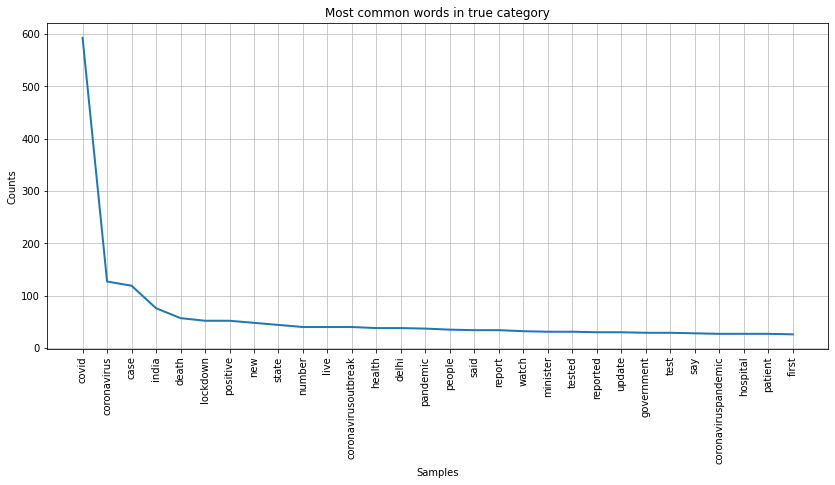

In [12]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_true).plot(30,
                             title='Most common words in true category')
plt.show()

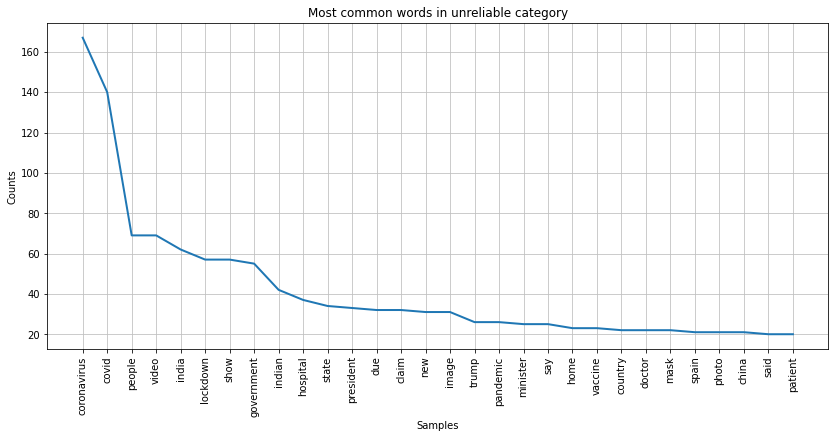

In [13]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_unreliable).plot(30,
                             title='Most common words in unreliable category')
plt.show()

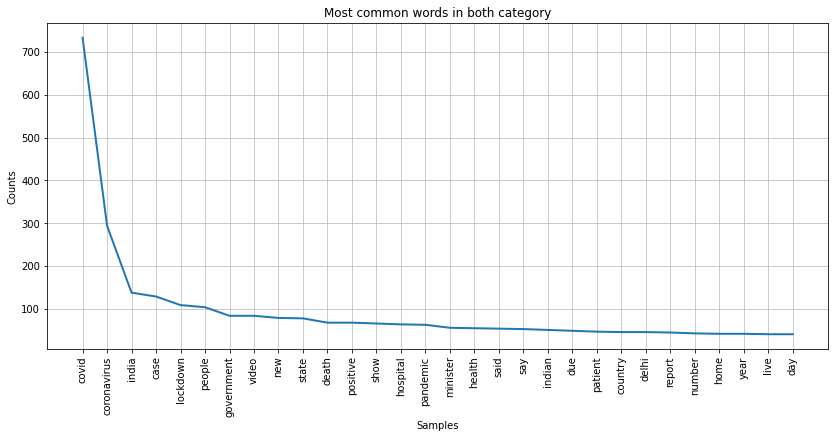

In [14]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow).plot(30,
                             title='Most common words in both category')
plt.show()

#### size of vocabulary (distinct words)

In [15]:
len(set(bow_true))

2388

In [16]:
len(set(bow_unreliable))

2446

In [17]:
len(set(bow_true) & set(bow_unreliable))

909

In [18]:
common_500_words = [i[0] for i in nltk.FreqDist(bow).most_common(500)]

In [19]:
common_500_words[:10]

['covid',
 'coronavirus',
 'india',
 'case',
 'lockdown',
 'people',
 'government',
 'video',
 'new',
 'state']

In [20]:
true_tweets = [tweet for tweet in df[df.category == 'true'].cleaned.str.split().to_list()]
unreliable_tweets = [tweet for tweet in df[df.category == 'unreliable'].cleaned.str.split().to_list()]

In [41]:
def matrix_creator(tweets, words):
    word_tweet = {word:np.zeros(len(tweets)) for word in words}
    for word in words:
        for i, tweet in enumerate(tweets):
            if word in tweet:
                word_tweet[word][i] += 1
    df = pd.DataFrame(word_tweet).T
    df.columns = ['t'+str(col) for col in df.columns.to_list()]
    df = df.reset_index().rename(columns={'index':'word'})
    return df
        

In [42]:
word_tweet_true_df = matrix_creator(true_tweets, common_500_words)
word_tweet_unreliable_df = matrix_creator(unreliable_tweets, common_500_words)

In [47]:
word_tweet_true_df.to_csv('../../ITEC-623/R/ITEC-623/final_project/data/true_word_tweet_matrix.csv', index=False)
word_tweet_unreliable_df.to_csv('../../ITEC-623/R/ITEC-623/final_project/data/false_word_tweet_matrix.csv', index=False)